# feature set 5 chromosomes 2, 3, 4 

## In this notebook:

* single input dataframe 
* using feature set 5 
* GradientBoostingClassifier 
* only training/test split, no epochs 
* aucuracy assessement : 
* feature importance for RF (mostly just amino acid position)

In [1]:
import torch
import pandas as pd
import numpy as np

# using sklearn goodies
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split


## pull in pickled dataframe:
df = pd.read_pickle("./pickled/chr2-4_featureset5.pkl")



print("shape before", df.shape)
df = df.replace({'.': 0})  ## FIXME: atm replace with nan and drop: later find a way to impute, maybe 0 but not sure
#print("SUM", pd.isnull(df).sum())  ## Use this to see how many elements have nan 
df = df.dropna()
print("shape after dropping all data with score = '.'", df.shape)
#print(df.head())

## still contains some mixed labels, see them by: df[~df['clinvar_clnsig'].isin(list(clinvar_labels.keys()))]

## Map labels to 1/0 and remove Unkn
clinvar_labels={
    'Pathogenic': 1,
    'Likely_pathogenic': 1,
    'Pathogenic/Likely_pathogenic': 1,
    'Benign/Likely_benign': 0,
    'Likely_benign': 0,
    'Benign': 0
}

#df.head()
#df = df[df['clinvar_clnsig'].isin(list(clinvar_labels.keys()))]  # best to drop everything that isn't in the dict
#df['Problematic'] = df['clinvar_clnsig'].map(clinvar_labels)

#df= df.drop(columns=['clinvar_clnsig'])#, 'clinvar_id'])  #tbh, I don't know why I kept them. consider adding to index

df = df.replace({'-': 0}) 
print("shape after dropping Unk", df.shape)
#df.head()

### pickle to reuse dataframe:
#df.to_pickle("./pickled_df/all_scores_chr18,20.pkl")


shape before (13820, 14)
shape after dropping all data with score = '.' (13820, 14)
shape after dropping Unk (13820, 14)


In [2]:
## Split into train/test
data_copy = df.copy()
df_train = data_copy.sample(frac=0.75, random_state=1)
df_test = data_copy.drop(df_train.index)

print ('Training data subset\n')
print (df_train.head(3))  # head default n=5, first 3 is enough
print ('\nTest data subset\n')
print (df_test.head(3))


## Get label:
train_labels = df_train.pop('Problematic')  # replace with clinvar when column is available
test_labels = df_test.pop('Problematic')

Training data subset

                       aapos codonpos  Polyphen2_HVAR_pred   GenoCanyon_score  \
chr pos       ref alt                                                           
2   222220292 G   A      341        1                    0  0.999999999414244   
4   95114733  T   C       53        1                   -2  0.999999997815507   
2   178694626 C   T    10150        1                    0  0.999728534038663   

                      LINSIGHT    RVIS_ExAC       ExAC_cnv.score  \
chr pos       ref alt                                              
2   222220292 G   A          0  0.126609025     1.41369465212203   
4   95114733  T   C          0  -0.03818213  -0.0678400328187906   
2   178694626 C   T          0  3.161811341                    0   

                       SORVA_LOF_MAF0.005_HetOrHom  Problematic  Mutation<1kb  \
chr pos       ref alt                                                           
2   222220292 G   A                       0.001198            1      

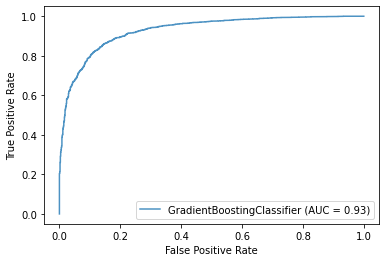

Confusion matrix: 
 [[ 721  255]
 [ 180 2257]]
Accuracy: 0.8725461470846763
Recall TP/(TP+FN): [0.73872951 0.9261387 ]
Precision TP/(TP+FP): [0.80022198 0.89848726]
F1: [0.7682472  0.91210346]


In [3]:
# Try a random forest:

forest = GradientBoostingClassifier(n_estimators=1000, random_state=42)
forest.fit(df_train, train_labels)
ax = plt.gca()
rfc_disp = plot_roc_curve(forest, df_test, test_labels, ax=ax, alpha=0.8)
#svc_disp.plot(ax=ax, alpha=0.8) ## if you want to plot both svm and rf
plt.show()

## metrics:
y_true = test_labels.to_numpy()
y_pred = forest.predict(df_test)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Confusion matrix: \n", confusion_matrix(y_true, y_pred))

# Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_true, y_pred))

# Recall
from sklearn.metrics import recall_score
recall = recall_score(y_true, y_pred, average=None)
print("Recall TP/(TP+FN):", recall)

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_true, y_pred, average=None)
print("Precision TP/(TP+FP):",precision)


# F1 score
F1 = 2 * (precision * recall) / (precision + recall)
print("F1:", F1)



### results of exp 11: n=10
Confusion matrix: 
 [[ 733  243]
 [ 251 2186]]
Accuracy: 0.855259302666276
Recall TP/(TP+FN): [0.75102459 0.89700451]
Precision TP/(TP+FP): [0.7449187  0.89995883]
F1: [0.74795918 0.89847924]

### results of exp 16: n=10
Confusion matrix: 
 [[ 455  521]
 [ 101 2336]]
Accuracy: 0.8177556401992382
Recall TP/(TP+FN): [0.46618852 0.9585556 ]
Precision TP/(TP+FP): [0.81834532 0.81764088]
F1: [0.59399478 0.8825085 ]

### results of exp 16: n=100
Confusion matrix: 
 [[ 585  391]
 [ 156 2281]]
Accuracy: 0.8397304424260181
Recall TP/(TP+FN): [0.59938525 0.93598687]
Precision TP/(TP+FP): [0.78947368 0.85366766]
F1: [0.68142108 0.89293404]

### results of exp 16: n=1000
Confusion matrix: 
 [[ 681  295]
 [ 180 2257]]
Accuracy: 0.8608262525637269
Recall TP/(TP+FN): [0.6977459 0.9261387]
Precision TP/(TP+FP): [0.79094077 0.88440439]
F1: [0.74142624 0.90479054]